In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

# 构建序列，序列字符以索引形式表示

batch_size = 2

# 单词表大小
max_num_src_words = 8 # 源序列单词总数
max_num_tgt_words = 8  

# 模型特征大小
model_dim = 8

# 最大序列长度
max_src_seq_len = 5
max_tgt_seq_len = 5

# 序列编码最大长度
max_position_len = 5

# 源序列长度 
src_len = torch.Tensor([2, 4]).to(torch.int32)
tgt_len = torch.Tensor([4, 3]).to(torch.int32)

# Step1:单词索引构成源句子和目标句子,构建batch，做了padding， 默认值为0
src_seq = torch.cat([ torch.unsqueeze(F.pad(torch.randint(1, max_num_src_words, (L, )), (0, max(src_len) - L)) ,0) 
                     for L in src_len])  
tgt_seq = torch.cat([ torch.unsqueeze(F.pad(torch.randint(1, max_num_tgt_words, (L, )), (0, max(tgt_len) - L)) ,0) 
                     for L in tgt_len])

# Step2:构造word_embedding
src_embedding_table = nn.Embedding(max_num_src_words + 1, model_dim)
tgt_embedding_table = nn.Embedding(max_num_tgt_words + 1, model_dim)
src_embedding = src_embedding_table(src_seq)
tgt_embedding = tgt_embedding_table(tgt_seq)

# Step3:构造position_embedding
pos_mat = torch.arange(max_position_len).reshape((-1, 1))
i_mat = torch.pow(10000, torch.arange(0, 8, 2).reshape((1, -1)) / model_dim)
pe_embedding_table = torch.zeros(max_position_len, model_dim)
pe_embedding_table[:, 0::2] = torch.sin(pos_mat / i_mat)
pe_embedding_table[:, 1::2] = torch.cos(pos_mat / i_mat)

pe_embedding = nn.Embedding(max_position_len, model_dim)
pe_embedding.weight = nn.Parameter(pe_embedding_table, requires_grad=False)

src_pos = torch.cat([torch.unsqueeze(torch.arange(max(src_len)), 0) for _ in src_len]).to(torch.int32)
tgt_pos = torch.cat([torch.unsqueeze(torch.arange(max(tgt_len)), 0) for _ in tgt_len]).to(torch.int32)

# 源序列和目标序列的位置编码矩阵
src_pe_embedding = pe_embedding(src_pos)
tgt_pe_embedding = pe_embedding(tgt_pos)

# Step4.构造encoder的self-attention mask 关系矩阵
# mask的shape: [batch_size, max_src_len, max_src_len] ， 值为1或-inf
# Q:(batch_size, max_src_len, model_dim)   K:(batch_size, max_src_len, model_dim) 
valid_encoder_pos = torch.unsqueeze(torch.cat([torch.unsqueeze(F.pad(torch.ones(L), (0, max(src_len)- L)), 0) for L in src_len]), 2)

# 有效位置矩阵 
valid_encoder_pos_matrix = torch.bmm(valid_encoder_pos, valid_encoder_pos.transpose(1, 2))
invalid_encoder_pos_matrix = 1- valid_encoder_pos_matrix
mask_encoder_self_attention = invalid_encoder_pos_matrix.to(torch.bool)

# score
score = torch.randn(batch_size, max(src_len), max(src_len))
masked_score = score.masked_fill(mask_encoder_self_attention, -1e9)
prob = F.softmax(masked_score, -1)

# Step5:构造intra-attention的mask
# Q @ K^T shape: [batch_size, tgt_seq_len, src_seq_len]
valid_encoder_pos = torch.unsqueeze(torch.cat([torch.unsqueeze(F.pad(torch.ones(L), (0, max(src_len)- L)), 0) for L in src_len]), 2)
valid_decoder_pos = torch.unsqueeze(torch.cat([torch.unsqueeze(F.pad(torch.ones(L), (0, max(tgt_len)- L)), 0) for L in tgt_len]), 2)

valid_cross_pos_matirx = torch.bmm(valid_decoder_pos, valid_encoder_pos.transpose(1, 2))
invalid_cross_pos_matrix = 1- valid_cross_pos_matirx
mask_cross_attention = invalid_cross_pos_matrix.to(torch.bool)

# Step6: decoder self-attention mask
lower = [torch.tril(torch.ones(L, L)) for L in tgt_len]


[tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]]), tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])]


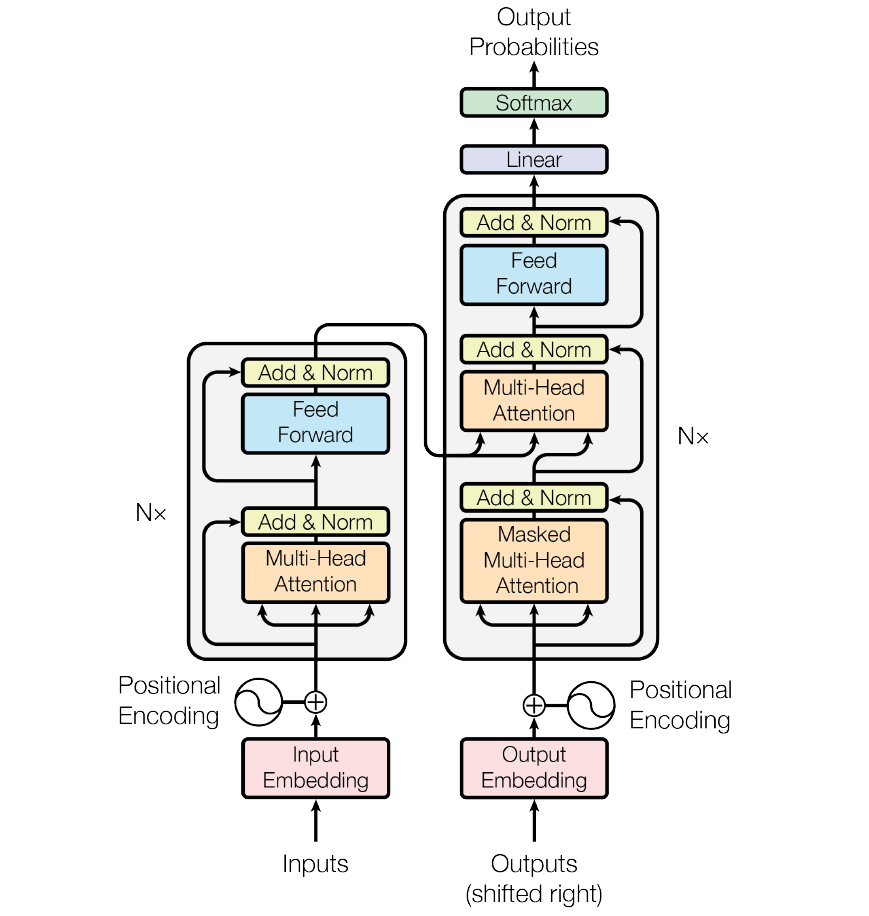![Alt text](image.png)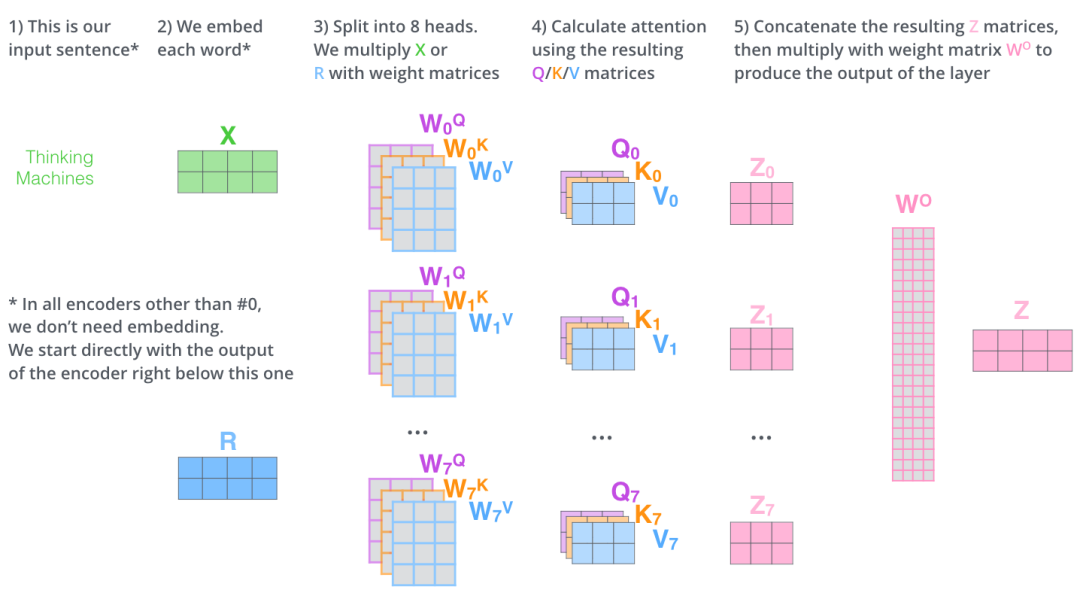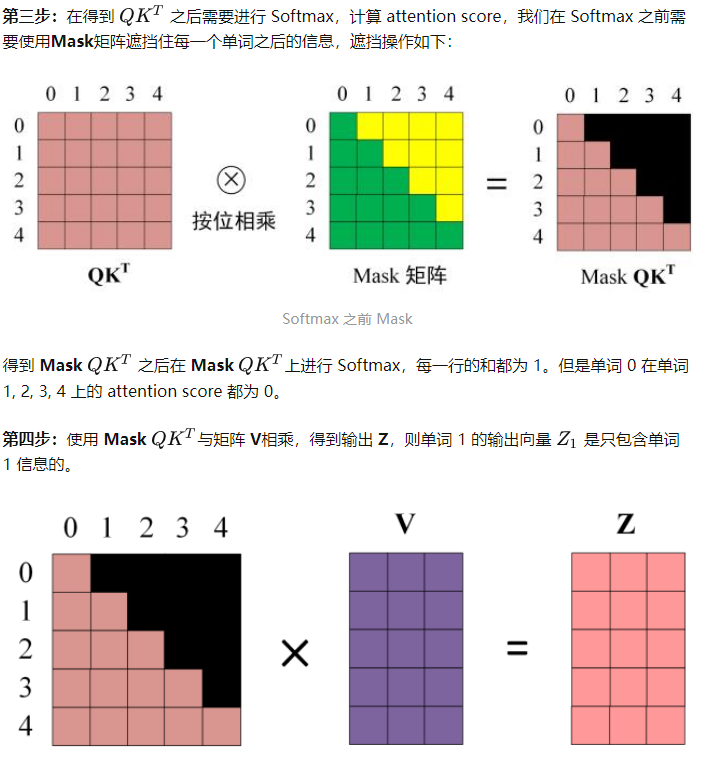 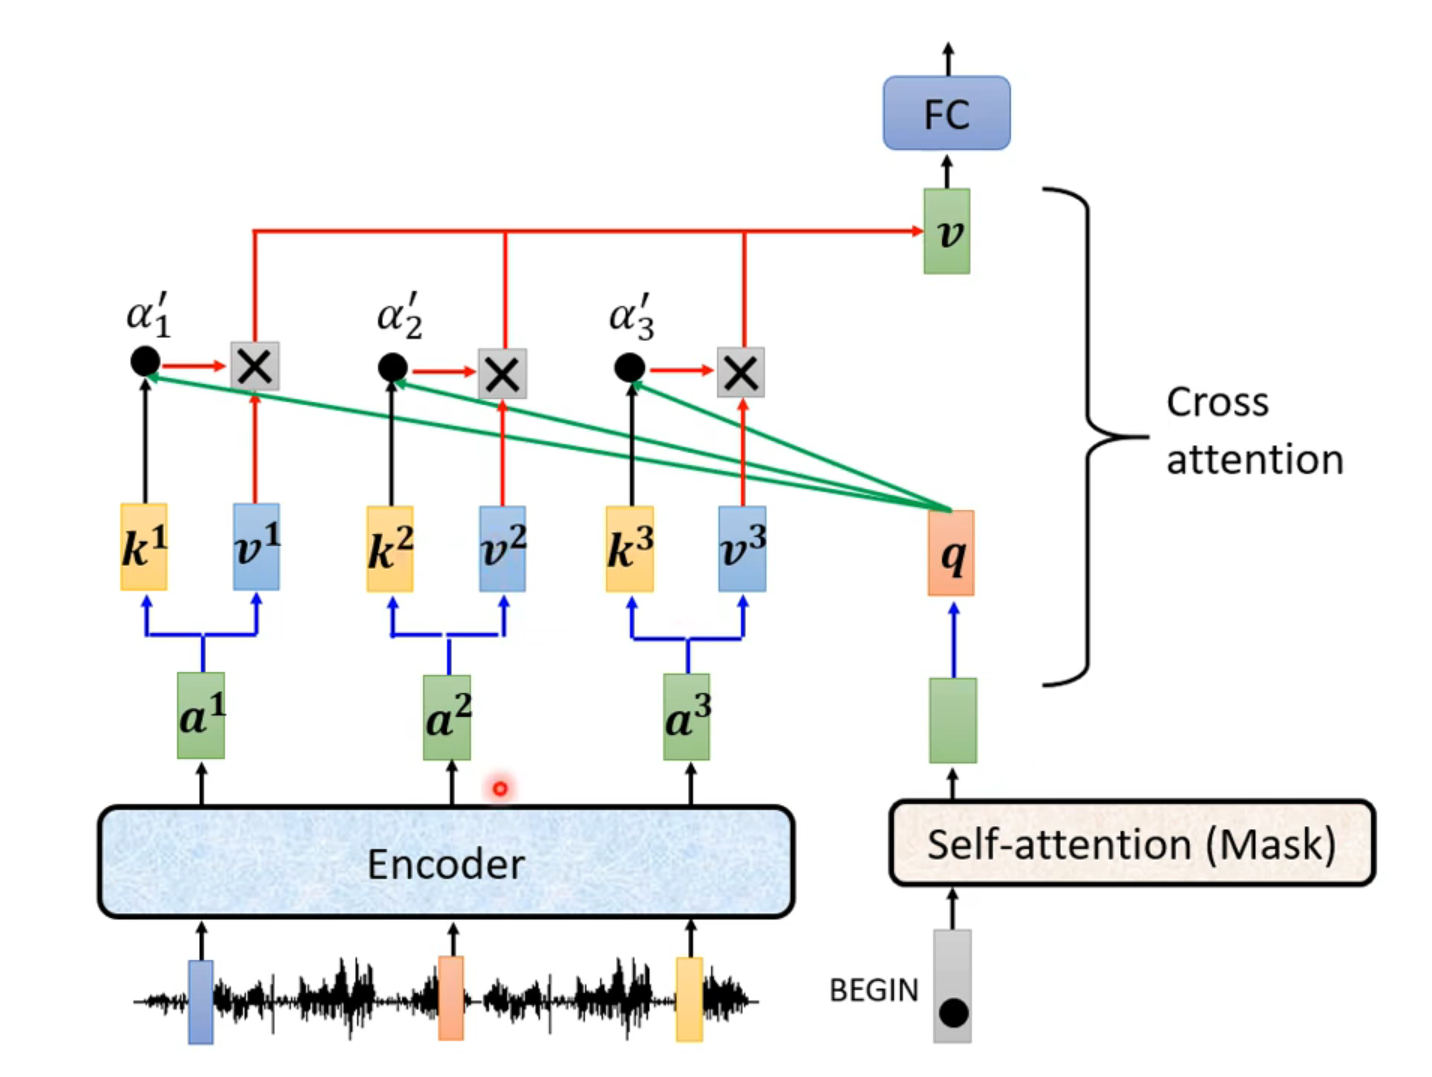